In [40]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='9ef31d26-29a3-4f2d-a293-a3c64c9e74db', project_access_token='p-47bb9b7dbf15c51becc46a25bb7d413bd2aa4c7b')
pc = project.project_context


In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

churn_file = project.get_file("Bank_Churn_2020_Train-20200210.json")
churn_df = pd.read_json(churn_file) # parse to a Pandas DataFrame using pd.read_csv()
# Take a look at the first 5 rows
churn_df.head()

,Active,Age,Balance,BankCC,ClientID,FICOScore,Firstname,Gender,LifeInsur,PlatStatus,Products,RegDeposits,Subsidiary,Surname,Terminated
0,0,37,122113.33,1,40ATL20120GM80095097706311P,624,Mindy,Female,1,1,2,5007,Atlanta,Graci,0
1,0,39,0.00,0,91CHL20100VI26913599075505N,670,Iraida,Female,1,0,2,7835,Chapel Hill,Veness,0
2,0,32,87992.57,0,61BOS20130LH10246893211788N,746,Hector,Male,0,0,1,8401,Boston,Latimore,0
3,0,36,1970.80,1,61BOS20150AC6028668471081P,796,Clifford,Male,1,1,2,8931,Boston,Aerts,0
4,0,49,83892.12,1,61BOS20190SR10901609271524N,584,Romeo,Male,0,0,1,8353,Boston,Swestka,1


# Introduction
Before selecting a model, we explored and cleaned the data.  We created a dataframe from the bank church json file’s data.  After examining the first five entries of the data, we recognized that our attribute of interest, in the Terminated column, is represented by a binary variable.  We used DataFrame.describe() to view summary statistics for quantitative attributes and DataFrame.info() to examine how each attribute is encoded.

In [42]:
churn_df.describe()

,Active,Age,Balance,BankCC,FICOScore,LifeInsur,Products,RegDeposits,Terminated
count,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000
mean,0.456208,39.214583,7.266221e+04,0.637333,624.726250,0.280250,1.530042,9.712217e+03,0.243292
std,0.498173,10.759454,6.475290e+05,0.480866,105.347391,0.449131,0.696085,4.400865e+04,0.429079
min,0.000000,3.000000,-1.283727e+05,0.000000,0.000000,0.000000,0.000000,-2.340000e+03,0.000000
25%,0.000000,32.000000,4.508350e+02,0.000000,552.000000,0.000000,1.000000,4.813000e+03,0.000000
50%,0.000000,38.000000,8.311797e+04,1.000000,624.000000,0.000000,1.000000,9.460500e+03,0.000000
75%,1.000000,45.000000,1.124337e+05,1.000000,696.000000,1.000000,2.000000,1.407400e+04,0.000000
max,2.000000,128.000000,1.000000e+08,2.000000,990.000000,1.000000,26.000000,6.775433e+06,1.000000


In [43]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 15 columns):
Active         24000 non-null int64
Age            24000 non-null int64
Balance        24000 non-null float64
BankCC         24000 non-null int64
ClientID       24000 non-null object
FICOScore      24000 non-null int64
Firstname      24000 non-null object
Gender         24000 non-null object
LifeInsur      24000 non-null int64
PlatStatus     24000 non-null object
Products       24000 non-null int64
RegDeposits    24000 non-null int64
Subsidiary     24000 non-null object
Surname        24000 non-null object
Terminated     24000 non-null int64
dtypes: float64(1), int64(8), object(6)
memory usage: 2.7+ MB


# Variables in Data
* ClientID:  unique identifier of the bank customer
* Surname: surname of customer
* Firstname: firstname of customer
* FICOScore: the average credit score of the customer in the past year
* Subsidiary: the bank subsidiary that manages the customer relationship
* Gender: Female or Male
* Age: age of customer
* Balance: total balance across all accounts (if applicable) such as checking, savings and credit
* Product: number of banking products the customer uses
* BankCC: whether the customer has a credit card from the bank
* Active: indicates an active customer with regular transactions in the past 3 months
* RegDeposits: average monthly deposits that are made to the account across the past year (e.g., salary or pension)
* LifeInsur: whether the customer has a special life insurance policy from the bank
* PlatStatus: whether the customer has Platinum status at the bank (receives several perks and better service)
* Terminated: whether the customer closed their accounts with the bank within the 6 months following the download of the data from the bank's database

# Cleaning the Data:
First, we examined categorical attributes.  When examining the Gender attribute, we noticed that one customer had a listed gender of ‘Feale’ instead of ‘Female’, so we corrected this misspelling.  We converted the Subsidiary and Gender values from strings into categories, since all customers belong to one of two genders, Male and Female, and one of three subsidiaries, Atlanta, Boston, and Chapel Hill.  We created two numerical variables, Gen_id and Sub_id, which represent these categories.  The Gen_id variable specifically can act as a binary attribute useful for models.


In [44]:
unique_subsidiary = churn_df['Subsidiary'].unique()
print(unique_subsidiary)
#we see there are only three subsidiaries so we convert this to categorical 


['Atlanta' 'Chapel Hill' 'Boston']


In [45]:
churn_df['Subsidiary'] = churn_df['Subsidiary'].astype('category')
churn_df['Sub_id'] = churn_df['Subsidiary'].cat.codes
churn_df.head()
#integer codes placed alphabetically Atlanta is 0, Boston is 1, Chapel Hill is 2

,Active,Age,Balance,BankCC,ClientID,FICOScore,Firstname,Gender,LifeInsur,PlatStatus,Products,RegDeposits,Subsidiary,Surname,Terminated,Sub_id
0,0,37,122113.33,1,40ATL20120GM80095097706311P,624,Mindy,Female,1,1,2,5007,Atlanta,Graci,0,0
1,0,39,0.00,0,91CHL20100VI26913599075505N,670,Iraida,Female,1,0,2,7835,Chapel Hill,Veness,0,2
2,0,32,87992.57,0,61BOS20130LH10246893211788N,746,Hector,Male,0,0,1,8401,Boston,Latimore,0,1
3,0,36,1970.80,1,61BOS20150AC6028668471081P,796,Clifford,Male,1,1,2,8931,Boston,Aerts,0,1
4,0,49,83892.12,1,61BOS20190SR10901609271524N,584,Romeo,Male,0,0,1,8353,Boston,Swestka,1,1


In [46]:
unique_gender = churn_df['Gender'].unique()
print(unique_gender)
#Found spelling error for female so we need to change before changing to binary response

['Female' 'Male' 'Feale']


In [47]:
churn_df['Gender']= churn_df['Gender'].replace('Feale', 'Female')
unique_gender2 = churn_df['Gender'].unique()
print(unique_gender2)
#fix Gender feature by getting rid of mislabeled date point with correct label

['Female' 'Male']


In [48]:
churn_df['Gender'] = churn_df['Gender'].astype('category')
churn_df['Gen_id'] = churn_df['Gender'].cat.codes
churn_df.head()

,Active,Age,Balance,BankCC,ClientID,FICOScore,Firstname,Gender,LifeInsur,PlatStatus,Products,RegDeposits,Subsidiary,Surname,Terminated,Sub_id,Gen_id
0,0,37,122113.33,1,40ATL20120GM80095097706311P,624,Mindy,Female,1,1,2,5007,Atlanta,Graci,0,0,0
1,0,39,0.00,0,91CHL20100VI26913599075505N,670,Iraida,Female,1,0,2,7835,Chapel Hill,Veness,0,2,0
2,0,32,87992.57,0,61BOS20130LH10246893211788N,746,Hector,Male,0,0,1,8401,Boston,Latimore,0,1,1
3,0,36,1970.80,1,61BOS20150AC6028668471081P,796,Clifford,Male,1,1,2,8931,Boston,Aerts,0,1,1
4,0,49,83892.12,1,61BOS20190SR10901609271524N,584,Romeo,Male,0,0,1,8353,Boston,Swestka,1,1,1


Next, we examined numerical attributes.  After running DataFrame.describe(), we noticed that the Age attribute had a maximum value of 128 and a minimum value of 3.  The entry with an age of 128 was the only entry with an age over 110, so we removed this entry.  Entries with ages of 3 and 7 were the only entries with ages below 15, so we also removed these entries.  The entry with the age of 7 was also the only entry with a FICOScore of less than 250, which is considered to be a minimum threshold.  Around 90 entries had FICOScores greater than 900, which is considered to be a maximum threshold, but we kept these entries under the assumption that the bank uses a valid FICOScore scale different from typical scales.

In [49]:
print(churn_df[churn_df['Age'] > 100])
#theres an outlier with a person who is of age 128 we will remove that to prevent this value from being an outlier for age based prediction
churn_df = churn_df.drop(churn_df[churn_df['Age']  > 100].index)

      Active  Age   Balance  BankCC                     ClientID  FICOScore  \
9989       0  128  83344.54       0  40ATL20130ZD81127368052957N        470   

      Firstname Gender  LifeInsur PlatStatus  Products  RegDeposits  \
9989  Dominique   Male          0          0         1         8354   

     Subsidiary Surname  Terminated  Sub_id  Gen_id  
9989    Atlanta   Zilch           0       0       1  


In [50]:
churn_df.describe()

,Active,Age,Balance,BankCC,FICOScore,LifeInsur,Products,RegDeposits,Terminated,Sub_id,Gen_id
count,23999.000000,23999.000000,2.399900e+04,23999.000000,23999.000000,23999.000000,23999.000000,2.399900e+04,23999.000000,23999.000000,23999.000000
mean,0.456227,39.210884,7.266176e+04,0.637360,624.732697,0.280262,1.530064,9.712273e+03,0.243302,0.990250,0.533189
std,0.498174,10.744403,6.475425e+05,0.480859,105.344851,0.449136,0.696091,4.400956e+04,0.429085,0.709599,0.498908
min,0.000000,3.000000,-1.283727e+05,0.000000,0.000000,0.000000,0.000000,-2.340000e+03,0.000000,0.000000,0.000000
25%,0.000000,32.000000,4.508300e+02,0.000000,552.000000,0.000000,1.000000,4.813000e+03,0.000000,0.000000,0.000000
50%,0.000000,38.000000,8.311368e+04,1.000000,624.000000,0.000000,1.000000,9.461000e+03,0.000000,1.000000,1.000000
75%,1.000000,45.000000,1.124358e+05,1.000000,696.000000,1.000000,2.000000,1.407400e+04,0.000000,1.000000,1.000000
max,2.000000,93.000000,1.000000e+08,2.000000,990.000000,1.000000,26.000000,6.775433e+06,1.000000,2.000000,1.000000


We also noticed that the Active and BankCC attributes, represented as integers, had a maximum value of 2.  These attributes, based on their definitions, should be binary.  Unable to assume whether a 2 should represent a 1 or a 0, we removed entries with an Active or BankCC attribute equal to 2. 

In [51]:
#From the describe table we see that the max for Active and
#BankCC is 2 when both variables should be of binary values

unique_active = churn_df['Active'].unique()
print(unique_active)
unique_cc = churn_df['BankCC'].unique()
print(unique_cc)
#from this we see there are instances in the data where Active
#and BankCC are 2 so we need to find where and discern id this
#is a piece of bad data

[0 1 2]
[1 0 2]


In [52]:
print(churn_df[churn_df['Active'] == 2])
len(churn_df[churn_df['Active'] == 2])

     Active  Age    Balance  BankCC                     ClientID  FICOScore  \
287       2   41  108626.87       0  40ATL20120OC92211305173871N        645   

     Firstname Gender  LifeInsur PlatStatus  Products  RegDeposits Subsidiary  \
287  Christian   Male          0          0         1        12995    Atlanta   

        Surname  Terminated  Sub_id  Gen_id  
287  Ohlshausen           0       0       1  


1

In [53]:
print(churn_df[churn_df['BankCC'] == 2])
len(churn_df[churn_df['BankCC'] == 2])


       Active  Age  Balance  BankCC                     ClientID  FICOScore  \
11910       0   40      0.0       2  91CHL20160SI36244582572755N        921   

      Firstname Gender  LifeInsur PlatStatus  Products  RegDeposits  \
11910      Ingo   Male          0          0         1         3352   

        Subsidiary   Surname  Terminated  Sub_id  Gen_id  
11910  Chapel Hill  Schachel           0       2       1  


1

In [54]:
# Now we see that from both Active and BankCC there is one
#instance each that has been mislabeled. Instead of making
#an assumption on activeness or owning a credit card we 
#elected to remove both instance of mislabeled data
churn_df = churn_df.drop(churn_df[churn_df['Active'] == 2].index)
churn_df = churn_df.drop(churn_df[churn_df['BankCC'] == 2].index)

In [55]:
churn_df.describe()

,Active,Age,Balance,BankCC,FICOScore,LifeInsur,Products,RegDeposits,Terminated,Sub_id,Gen_id
count,23997.000000,23997.000000,2.399700e+04,23997.000000,23997.000000,23997.000000,23997.000000,2.399700e+04,23997.000000,23997.000000,23997.00000
mean,0.456182,39.210776,7.266329e+04,0.637330,624.719507,0.280285,1.530108,9.712401e+03,0.243322,0.990249,0.53315
std,0.498087,10.744843,6.475692e+05,0.480781,105.331796,0.449148,0.696103,4.401137e+04,0.429097,0.709569,0.49891
min,0.000000,3.000000,-1.283727e+05,0.000000,0.000000,0.000000,0.000000,-2.340000e+03,0.000000,0.000000,0.00000
25%,0.000000,32.000000,4.508400e+02,0.000000,552.000000,0.000000,1.000000,4.813000e+03,0.000000,0.000000,0.00000
50%,0.000000,38.000000,8.311368e+04,1.000000,624.000000,0.000000,1.000000,9.461000e+03,0.000000,1.000000,1.00000
75%,1.000000,45.000000,1.124401e+05,1.000000,696.000000,1.000000,2.000000,1.407400e+04,0.000000,1.000000,1.00000
max,1.000000,93.000000,1.000000e+08,1.000000,990.000000,1.000000,26.000000,6.775433e+06,1.000000,2.000000,1.00000


Additionally, we noticed that PlatinumStatus, another binary attribute, was represented by objects.  We examined the unique values of this attribute and found one entry with PlatinumStatus encoded as ‘yes’ instead of 1.  We changed this entry’s PlatinumStatus value to 1, then converted the PlatinumStatus values from strings to categories.

In [57]:

churn_df['PlatStatus']= churn_df['PlatStatus'].replace('yes', '1')

churn_df['PlatStatus'] = churn_df['PlatStatus'].astype('category')
unique_plat = churn_df['PlatStatus'].unique()

print(unique_plat)

[1, 0]
Categories (2, object): [1, 0]


Finally, we noticed that the Balance and RegDeposits attributes had negative entries.  2719 entries had negative balances, so we assumed that these entries are valid and represent customers in debt.  However, only one entry had a negative regular deposits amount.  We decided that removing this entry was safer than making an assumption about what that negative value represents. 

In [80]:
churn_df = churn_df.drop(churn_df[churn_df['RegDeposits'] == -2340].index)

As a final measure, we checked the data for null values and found none.


In [79]:
churn_df.isnull().sum()

Active         0
Age            0
Balance        0
BankCC         0
ClientID       0
FICOScore      0
Firstname      0
Gender         0
LifeInsur      0
PlatStatus     0
Products       0
RegDeposits    0
Subsidiary     0
Surname        0
Terminated     0
Sub_id         0
Gen_id         0
dtype: int64

To prepare for model creation, we created a basic pie chart to see what pecentage of customers had left the bank and what percentage was retained. To do this we used the matplotlib. Then we used seaborn pair plots to get a basic visual overview of the data using pair plots. After, we encoded all binary attributes, including PlatStatus and Terminated,  as boolean types.

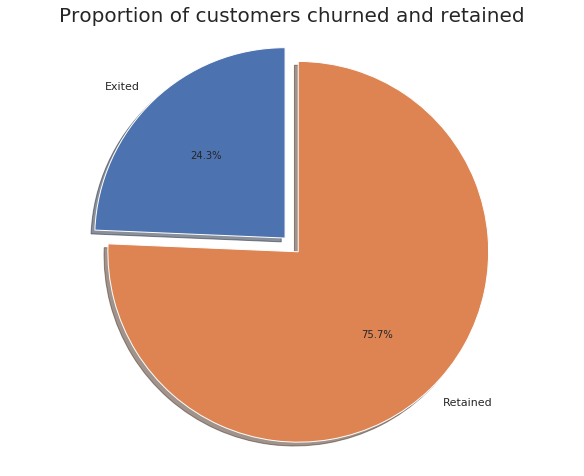

In [81]:
%matplotlib inline

labels = 'Exited', 'Retained'
sizes = [churn_df.Terminated[churn_df['Terminated']==1].count(), churn_df.Terminated[churn_df['Terminated']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customers churned and retained", size = 20)
plt.show()

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


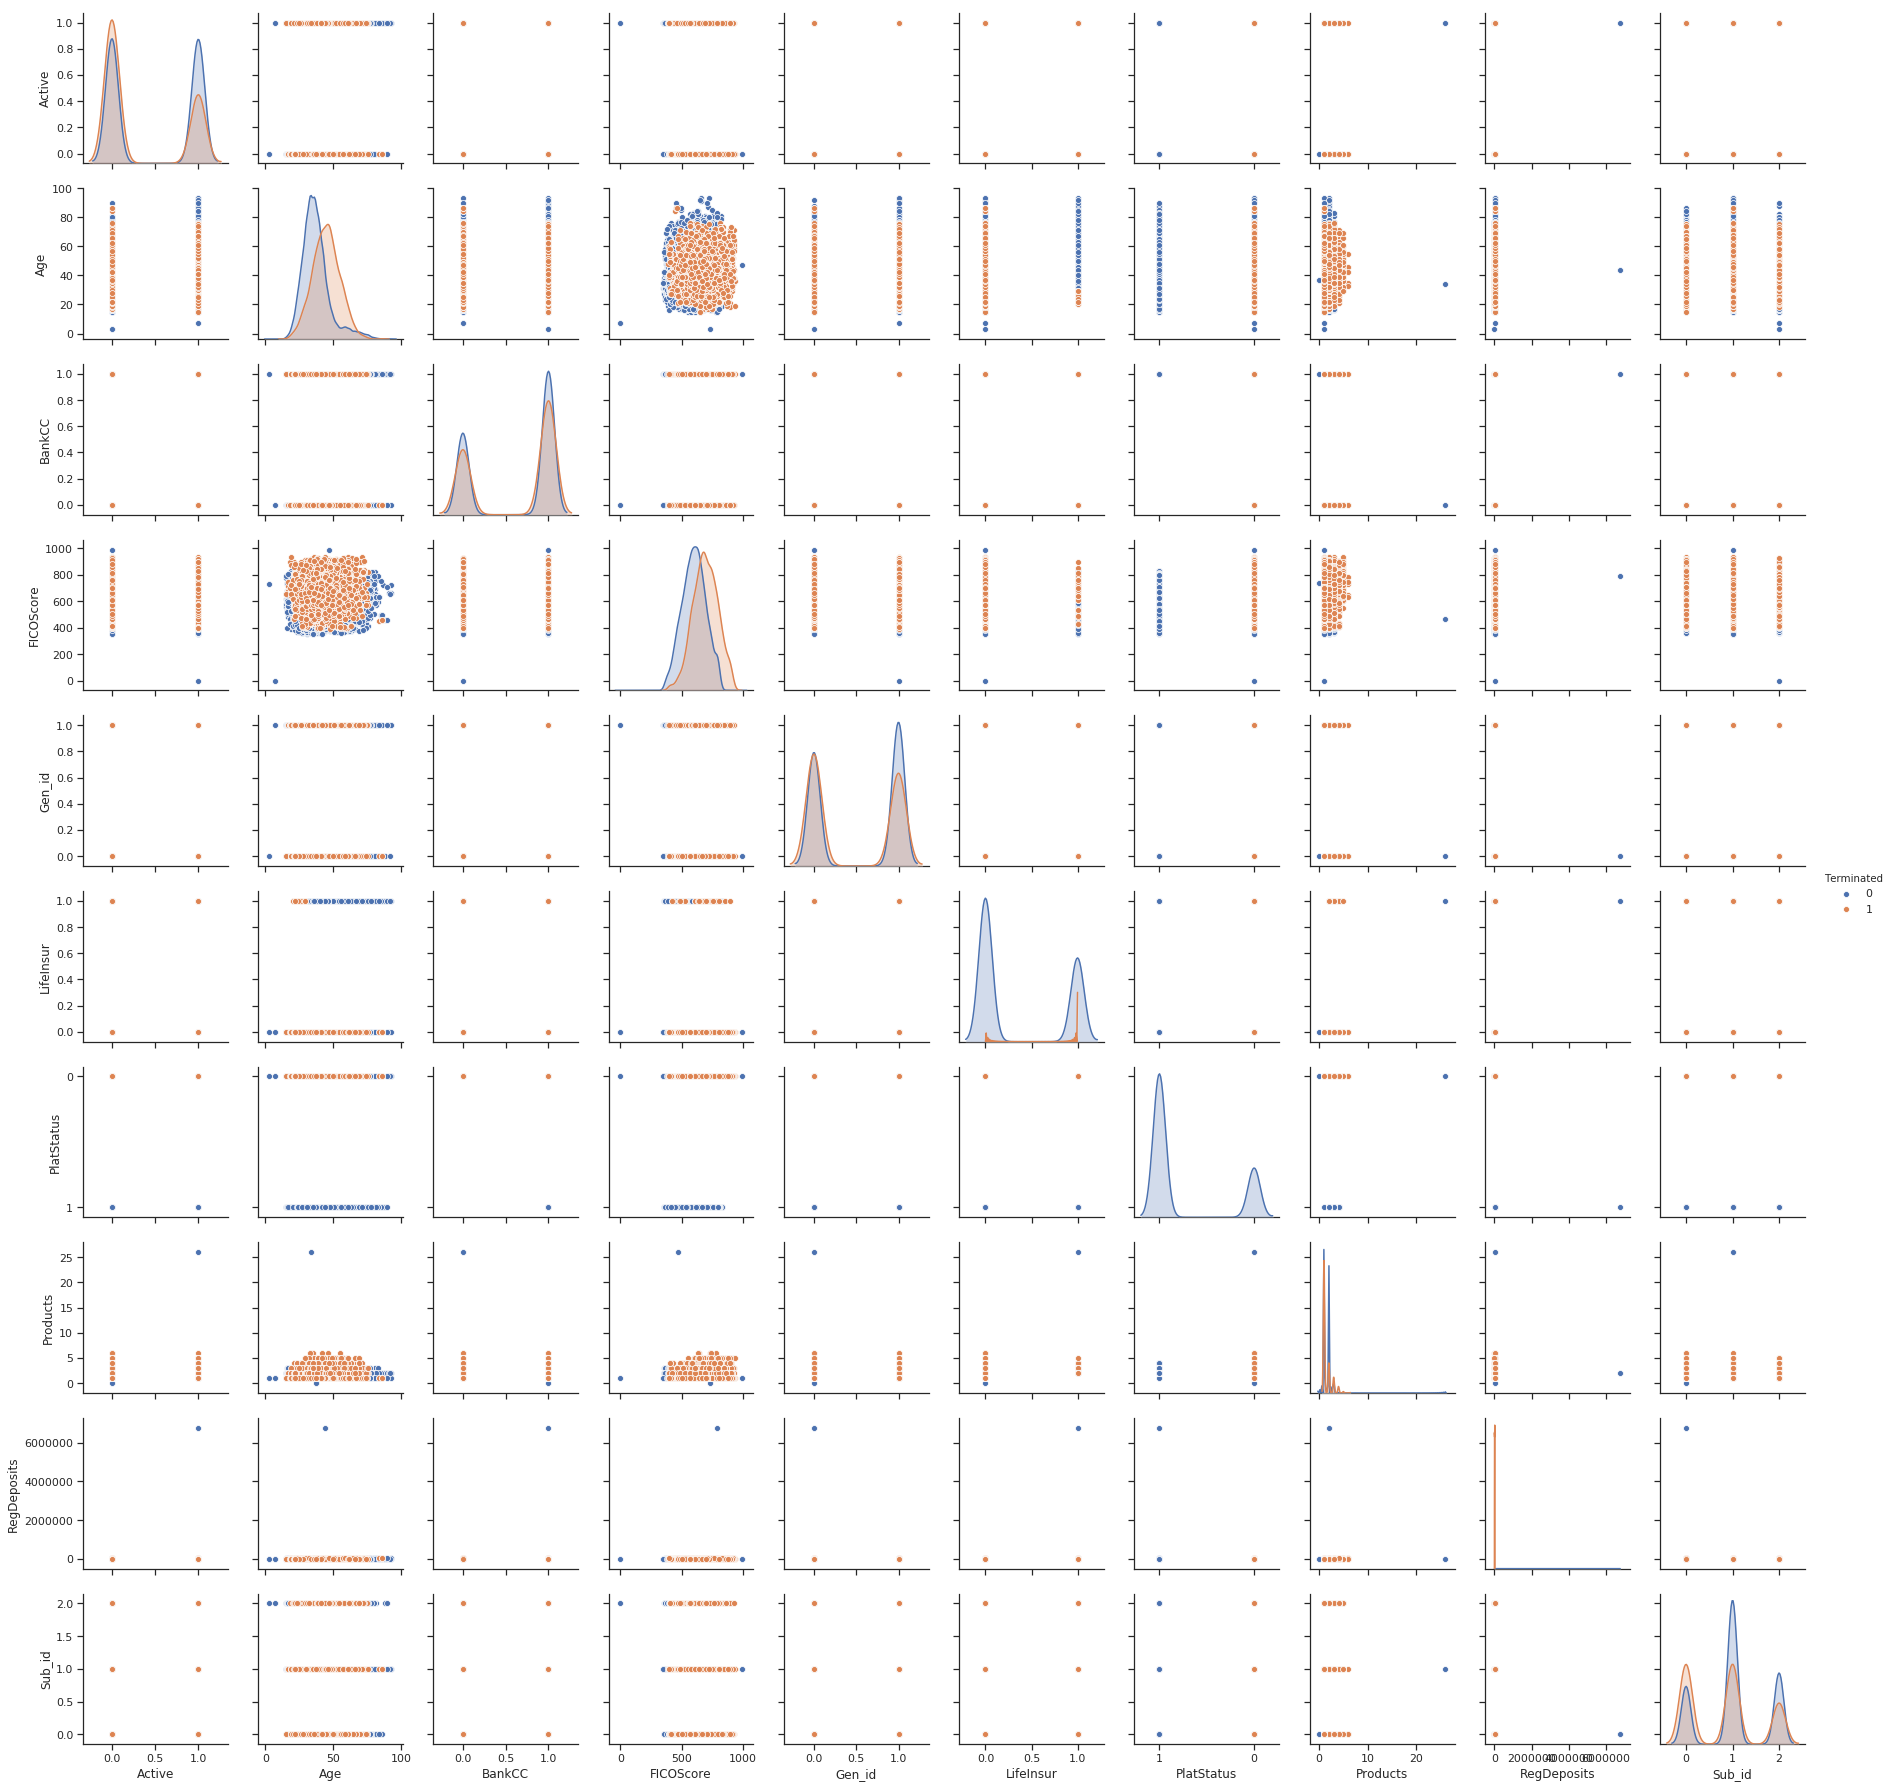

In [60]:
#For data exporation create a pair plot to see relationships with different features
sns.set(style="ticks")
sns.pairplot(churn_df, vars=['Active','Age', 'BankCC','FICOScore', 'Gen_id', 'LifeInsur', 'PlatStatus', 'Products', 'RegDeposits', 'Sub_id' ], hue='Terminated')

In [61]:
#change datatype of binary variables to boolean for model
for i in ['Active', 'BankCC', 'LifeInsur', 'Sub_id', 'Gen_id', 'Terminated']:
    churn_df[i] = churn_df[i].astype(bool)

churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23996 entries, 0 to 23999
Data columns (total 17 columns):
Active         23996 non-null bool
Age            23996 non-null int64
Balance        23996 non-null float64
BankCC         23996 non-null bool
ClientID       23996 non-null object
FICOScore      23996 non-null int64
Firstname      23996 non-null object
Gender         23996 non-null category
LifeInsur      23996 non-null bool
PlatStatus     23996 non-null category
Products       23996 non-null int64
RegDeposits    23996 non-null int64
Subsidiary     23996 non-null category
Surname        23996 non-null object
Terminated     23996 non-null bool
Sub_id         23996 non-null bool
Gen_id         23996 non-null bool
dtypes: bool(6), category(3), float64(1), int64(4), object(3)
memory usage: 2.5+ MB


# Assumptions: 
Our models assume that all customers with age ranges 15-110, FICO Scores above 250, and valid values for other attributes are valid customers.  The model also assumes that customers can have negative balances. 


# Models:
From class discussions, we had an idea about several different models that we wanted to explore (RFE, logistic regression, and knn), but we did not know which variables we should value the most when training the model. 

First, we tried to use recursive feature elimination analysis, also known as RFE analysis, to identify the top attributes to use in a logistic regression model.  Before performing this analysis, we dropped the ClientID, Firstname, Surname, Gender, and Subsidiary attributes from the cleaned data because the RFE analysis requires numerical data.  Gen_id represents gender numerically.  We also removed Sub_id, because this data uses numerical values to represent categories, but the RFE analysis would view these values as quantities.  The RFE analysis recommended keeping all remaining attributes.  However, when we created a logistic regression model with these attributes, we only achieved an accuracy of around 76 percent.

In [84]:
# Import machine learning models, and the ability to split data into testing and training segments
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import RFE
import statsmodels.api as sm

# Set the y data to be the Terminated column
y = churn_df['Terminated']
# Set the x data to be the prescense of life insurance
X = churn_df[['LifeInsur']]

# Split the data into training and testing data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
columns = X_train.columns

# Instantiate the model
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

# Predict the y data
y_pred = logreg.predict(X_test)
# Print the accuracy of the logistic model, for LifeInsur
print((logreg.score(X_test, y_test)))

0.757792965494249


In [85]:
# Drop ClientID, Surname, and FirstName, as these should not correlate
# Also drop Gender, because it is represented by gender id
RFE_df = churn_df.drop(['ClientID','Firstname','Surname','Gender'], axis=1)

# First try the model by dropping subsidiary
# Can later try the model using dummy subsidiary variables or by individually
#   examining each subsidiary.
RFE_df = RFE_df.drop(['Subsidiary','Sub_id'], axis=1)
RFE_df.head()

,Active,Age,Balance,BankCC,FICOScore,LifeInsur,PlatStatus,Products,RegDeposits,Terminated,Gen_id
0,False,37,122113.33,True,624,True,1,2,5007,False,False
1,False,39,0.00,False,670,True,0,2,7835,False,False
2,False,32,87992.57,False,746,False,0,1,8401,False,True
3,False,36,1970.80,True,796,True,1,2,8931,False,True
4,False,49,83892.12,True,584,False,0,1,8353,True,True


In [86]:
# Run RFE Analysis on the churn df

# Create training and testing data
y = RFE_df['Terminated']
X = RFE_df.drop(['Terminated'], axis=1)
X_train, X_test, y_train, t_test = train_test_split(X, y, test_size=0.3)

# Create a list of the X and y variables to use
RFE_vars = RFE_df.columns.values.tolist()
print(RFE_vars)
y_vars=['Terminated']
X_vars=[i for i in RFE_vars if i not in y]

# Run the RFE model
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

['Active', 'Age', 'Balance', 'BankCC', 'FICOScore', 'LifeInsur', 'PlatStatus', 'Products', 'RegDeposits', 'Terminated', 'Gen_id']
[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [87]:
# First, check for the accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

# The RFE predicts that all attributes can be useful for the model
# Now implement the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=70)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print(logreg.score(X_test, y_test))

0.764133907487151


In [88]:
# Describing more variables to help with the model
print(np.sort(churn_df['Age'].unique()))

[ 3  7 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84
 85 86 87 88 90 91 92 93]


Second, we created another model that used a limited number of attributes.  We started with a simple logistic regression model that used only the top six characteristics from the random forest model.  However, we used “platinum status” instead of “balance” in order to decrease the variation of prediction accuracy. In the end, the logistic regression model had an average F1 score of 83.5% which is lower than the F1 score of random forest model.


In [90]:
from sklearn.metrics import confusion_matrix, classification_report

X = churn_df[['RegDeposits', 'FICOScore', 'PlatStatus', 'LifeInsur','Age']]
y = churn_df['Terminated'].values

sum = 0
for i in range(15):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
    logreg = LogisticRegression(solver='lbfgs')
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    print('Accuracy of Prediction: {:2f}'.format(logreg.score(X_test, y_test)))
    sum += logreg.score(X_test, y_test)
avg = sum/15
print("Average is:", avg)

Accuracy of Prediction: 0.842083
Accuracy of Prediction: 0.840833
Accuracy of Prediction: 0.824583
Accuracy of Prediction: 0.845417
Accuracy of Prediction: 0.832500
Accuracy of Prediction: 0.830417
Accuracy of Prediction: 0.822500
Accuracy of Prediction: 0.822917
Accuracy of Prediction: 0.832500
Accuracy of Prediction: 0.846667
Accuracy of Prediction: 0.831250
Accuracy of Prediction: 0.825417
Accuracy of Prediction: 0.833750
Accuracy of Prediction: 0.831667
Accuracy of Prediction: 0.832083
Average is: 0.8329722222222223


Before creating the KNN model, we created a new X matrix of feature values and a y vector of response values.  The y vector uses the Terminated attribute, and the X vector uses all other attributes, except for ClientID, Firstname, Subsidiary, Gender, and Surname, which have non-numerical data values.

In [62]:
#create numpy vectors of feature values and response values
X = churn_df.drop(['ClientID', 'Firstname', 'Subsidiary', 'Gender', 'Surname', 'Terminated'], axis=1).values
y = churn_df['Terminated'].values

The third model that we tried is a KNN model.  We used sklearn to cross-validate the data, with the training data being four times the size of the testing data.  We calculated the accuracy of n-neighbor knn models for all n values between 1 and 30 and plotted these accuracies.  Generally, the accuracy increased with the number of neighbors. However, the accuracy leveled off around 75 percent after around 15 neighbors.  As the number of neighbors increases, we are also more likely to overfit the model to the training set.

X_train shape: (19196, 11)
y_train shape: (19196,)
X_test shape: (4800, 11)
y_test shape: (4800,)
[0.7027083333333334, 0.755, 0.7216666666666667, 0.7520833333333333, 0.7316666666666667, 0.7545833333333334, 0.7389583333333334, 0.75625, 0.7441666666666666, 0.7552083333333334, 0.7475, 0.7560416666666666, 0.7483333333333333, 0.755625, 0.7489583333333333, 0.7577083333333333, 0.7541666666666667, 0.758125, 0.7541666666666667, 0.7585416666666667, 0.7570833333333333, 0.76, 0.7597916666666666, 0.7604166666666666, 0.75875, 0.7604166666666666, 0.7583333333333333, 0.7595833333333334, 0.7575]


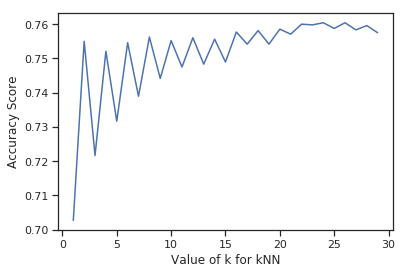

In [63]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)  # random_state=21 # stratify=y

# Check if our sample is split as we expected
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))


# import the k-nearest neighbors classifier from sci-kit learn
from sklearn.neighbors import KNeighborsClassifier

#create score array to append accuracy scores for each different k, then we plot to see the difference in accuracy
score = []
for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    score.append(knn.score(X_test, y_test))
print(score)
plt.plot(range(1,30), score)
plt.xlabel('Value of k for kNN')
plt.ylabel('Accuracy Score')
plt.show()

Next, we used principal component analysis to transform the X matrix values into principal component values.  We divided this new principalComponents matrix and the original y vector into testing and training data, with the training data still four times the size of the testing data.  We once again plotted the accuracy of 30 KNN models.  The accuracy of the model once again increased with the number of neighbors, this time along a smoother path.  However, this time the accuracy leveled of around 85 percent.

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


X_train shape: (19196, 2)
y_train shape: (19196,)
X_test shape: (4800, 2)
y_test shape: (4800,)
[0.781875, 0.8035416666666667, 0.8054166666666667, 0.813125, 0.8147916666666667, 0.8179166666666666, 0.8241666666666667, 0.82625, 0.8295833333333333, 0.8310416666666667, 0.8329166666666666, 0.830625, 0.8341666666666666, 0.8325, 0.8358333333333333, 0.833125, 0.8364583333333333, 0.8341666666666666, 0.8370833333333333, 0.8347916666666667, 0.835625, 0.8320833333333333, 0.8354166666666667, 0.83375, 0.8335416666666666, 0.8354166666666667, 0.835625, 0.8341666666666666, 0.836875]


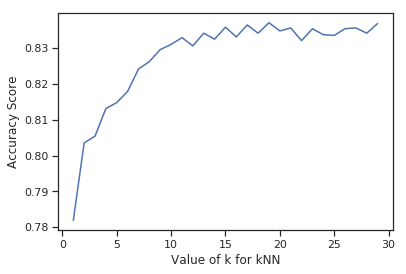

In [65]:
#Now that we have tried knn we try a knn using PCA and encode for two features
p_train, p_test, y_train, y_test = train_test_split(principalComponents, y, test_size=.2)  

# Check if our sample is split as we expected
print("X_train shape: {}".format(p_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(p_test.shape))
print("y_test shape: {}".format(y_test.shape))


# import the k-nearest neighbors classifier from sci-kit learn
from sklearn.neighbors import KNeighborsClassifier

#create score array to append accuracy scores for each different k, then we plot to see the difference in accuracy
pca_score = []
for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(p_train, y_train)
    pca_score.append(knn.score(p_test, y_test))
print(pca_score)
plt.plot(range(1,30), pca_score)
plt.xlabel('Value of k for kNN')
plt.ylabel('Accuracy Score')
plt.show()

After trying the KNN model, we explored other modeling techniques and came across random forest models.  We created random forest models of different tree sizes.  Models with larger tree sizes were slightly more accurate.  Overall, each random forest model made predictions with around 90 percent accuracy and achieved an average F1 score of around 90 percent. 

In [66]:
#Now we try a Random Forest Classifier
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = RandomForestRegressor(n_estimators=75, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [67]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#print the accuracy score as well as the classification report to observe f1-score
print(classification_report(y_test,y_pred.round()))
print(accuracy_score(y_test, y_pred.round()))

              precision    recall  f1-score   support

       False       0.92      0.95      0.94      3615
        True       0.84      0.75      0.79      1185

   micro avg       0.90      0.90      0.90      4800
   macro avg       0.88      0.85      0.86      4800
weighted avg       0.90      0.90      0.90      4800

0.903125


After building this model, we explored the attributes that the model weighed most important.  The most important attributes, in order, were Age, FICOScore, RegDeposits, LifeInsur, and Balance.  We created another random forest model that used an X matrix with only the top four attributes.  This model was less accurate than the other random forest models.

In [68]:
#Look at the importance of each feature within our model
importances = regressor.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

X_df = churn_df.drop(['ClientID', 'Firstname', 'Subsidiary', 'Gender', 'Surname', 'Terminated'], axis=1)
X_df.head()

Feature ranking:
1. feature 1 (0.230461)
2. feature 4 (0.217616)
3. feature 8 (0.145509)
4. feature 5 (0.133372)
5. feature 2 (0.107568)
6. feature 7 (0.061930)
7. feature 0 (0.031448)
8. feature 9 (0.021451)
9. feature 6 (0.020689)
10. feature 3 (0.016204)
11. feature 10 (0.013753)


,Active,Age,Balance,BankCC,FICOScore,LifeInsur,PlatStatus,Products,RegDeposits,Sub_id,Gen_id
0,False,37,122113.33,True,624,True,1,2,5007,False,False
1,False,39,0.00,False,670,True,0,2,7835,True,False
2,False,32,87992.57,False,746,False,0,1,8401,True,True
3,False,36,1970.80,True,796,True,1,2,8931,True,True
4,False,49,83892.12,True,584,False,0,1,8353,True,True


In [69]:
#Test different tree sizes
for i in [5, 10, 20, 100, 1000]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    regressor = RandomForestRegressor(n_estimators=i, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    print(classification_report(y_test,y_pred.round()))
    print(accuracy_score(y_test, y_pred.round()))

              precision    recall  f1-score   support

       False       0.91      0.94      0.93      3615
        True       0.79      0.73      0.76      1185

   micro avg       0.89      0.89      0.89      4800
   macro avg       0.85      0.83      0.84      4800
weighted avg       0.88      0.89      0.88      4800

0.8864583333333333
              precision    recall  f1-score   support

       False       0.91      0.96      0.93      3615
        True       0.84      0.70      0.76      1185

   micro avg       0.89      0.89      0.89      4800
   macro avg       0.87      0.83      0.85      4800
weighted avg       0.89      0.89      0.89      4800

0.8920833333333333
              precision    recall  f1-score   support

       False       0.91      0.96      0.93      3615
        True       0.84      0.72      0.77      1185

   micro avg       0.90      0.90      0.90      4800
   macro avg       0.88      0.84      0.85      4800
weighted avg       0.89      0.90   

# Key Findings:
After comparing different models, we recommend using the random forest model to predict whether a given customer will close their account.  To learn more about the data, we examined the attributes on which this model places the highest importance, specifically Age, FICOScore, RegDeposits, and LifeInsur.

In [70]:
#Age, FICOScore, LifeInsur, and RegDeposits in that order were the 4 most important features 
#fit a Random Forest using only these 4 features
X_new = churn_df.drop(['Active', 'Balance', 'BankCC', 'PlatStatus', 'Products', 'Sub_id', 'Gen_id', 
'ClientID', 'Firstname', 'Subsidiary', 'Gender', 'Surname', 'Terminated'], axis=1).values


X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print(classification_report(y_test,y_pred.round()))
print(accuracy_score(y_test, y_pred.round()))


              precision    recall  f1-score   support

       False       0.88      0.93      0.91      3615
        True       0.74      0.63      0.68      1185

   micro avg       0.85      0.85      0.85      4800
   macro avg       0.81      0.78      0.79      4800
weighted avg       0.85      0.85      0.85      4800

0.8541666666666666


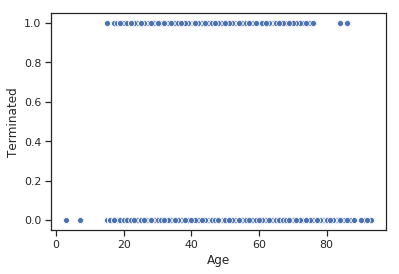

In [71]:
Age_df = churn_df.drop(['Active', 'Balance', 'BankCC', 'PlatStatus', 'Products', 'Sub_id', 'Gen_id', 
'ClientID', 'Firstname', 'Subsidiary', 'Gender', 'Surname', 'FICOScore', 'LifeInsur', 'RegDeposits'], axis=1)
ax = sns.scatterplot(x="Age", y="Terminated", data=Age_df)


For customers within 10 year age ranges, the probability of termination increased as the age range increased until peaking at a 60 percent termination rate for customers ages 50-59.  This rate decreased customers in the 60-69 age range and the 70 plus age range.


,Age,Terminated
agerange,,
0-17,16.778947,0.073684
18-29,26.575901,0.095412
30-39,35.527322,0.146910
40-49,44.643905,0.382903
50-59,54.896734,0.611431


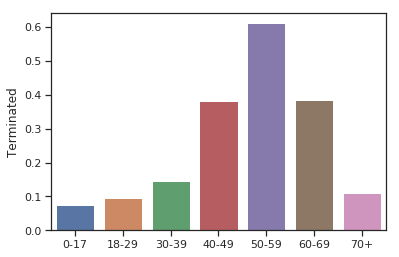

In [72]:
#create encoding for age groups
#take avergae of terminated across each age group
#plot bar plot with age group and mean
bins = [0, 18, 30, 40, 50, 60, 70, 120]
labels = ['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70+']
Age_df['agerange'] = pd.cut(Age_df.Age, bins, labels = labels,include_lowest = True)
Age_df.head()
#Age_df = Age_df.drop(['Age'])
Age_df2 = Age_df.groupby('agerange').mean()

sns.barplot(x=labels, y= 'Terminated', data=Age_df2)
Age_df2.head()

For FICO score ranges of 100, customers in higher ranges had a higher likelihood of termination.  After conducting outside research, however, we learned that banks typically have higher churn among customers with lower FICO scores.  This suggests that customers with good FICO scores are terminating their accounts in favor of more appealing banking options, possibly with lower interest rates on loans.  To appeal to these customers, we recommend improving interest rates for customers with good FICO score

,FICOScore,Terminated
FICOrange,,
300-399,382.503185,0.028662
400-499,462.018805,0.059366
500-599,555.802966,0.126799
600-699,648.327619,0.239881
700-799,744.806125,0.410663


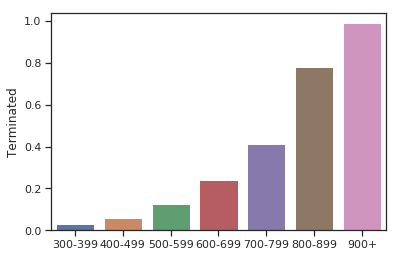

In [73]:
Fico_df = churn_df.drop(['Active', 'Balance', 'BankCC', 'PlatStatus', 'Products', 'Sub_id', 'Gen_id', 
'ClientID', 'Firstname', 'Subsidiary', 'Gender', 'Surname', 'Age', 'LifeInsur', 'RegDeposits'], axis=1)

Fico_df = Fico_df.drop(Fico_df[Fico_df['FICOScore']  < 300].index)
Fico_df.head()
bins = [300, 400, 500, 600, 700, 800, 900, 1000]
labels = ['300-399', '400-499', '500-599', '600-699', '700-799', '800-899', '900+']
Fico_df['FICOrange'] = pd.cut(Fico_df.FICOScore, bins, labels = labels,include_lowest = True)
Fico_df.head()
Fico_df2 =Fico_df.groupby('FICOrange').mean()   

sns.barplot(x=labels, y= 'Terminated', data=Fico_df2)
Fico_df2.head()

Customer termination rates remained consistent across RegDeposits value ranges.

In [74]:
Reg_dep_df = churn_df.drop(['Active', 'Balance', 'BankCC', 'PlatStatus', 'Products', 'Sub_id', 'Gen_id', 
'ClientID', 'Firstname', 'Subsidiary', 'Gender', 'Surname', 'Age', 'LifeInsur', 'FICOScore'], axis=1)

#len(churn_df[churn_df['RegDeposits']  > 25000])

Reg_dep_df = Reg_dep_df.drop(Reg_dep_df[Reg_dep_df['RegDeposits']  > 25000].index)
Reg_dep_df.head()
bins = [0, 5000, 10000, 15000, 20000, 25000]
labels = ['0-4999', '5000-9999', '10000-14999', '15000-19999', '20000+']
Reg_dep_df['DepRange'] = pd.cut(Reg_dep_df.RegDeposits, bins, labels = labels,include_lowest = True)
#Reg_dep_df.head()
Reg_dep_df.groupby('DepRange').mean() 


,RegDeposits,Terminated
DepRange,,
0-4999,2486.919140,0.240655
5000-9999,7510.224072,0.230945
10000-14999,12469.550048,0.249762
15000-19999,16913.336462,0.255050
20000+,NaN,NaN


Finally, customers with life insurance had only a 0.4 percent chance of termination, while customers without life insurance had a 33.6 percent chance.  This suggests that targeting customers with life insurance can help reduce churn.

,Terminated
LifeInsur,
False,0.336170
True,0.004907


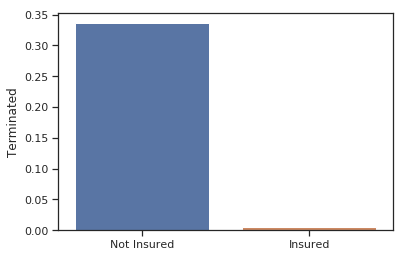

In [75]:
Life_insur_df = churn_df.drop(['Active', 'Balance', 'BankCC', 'PlatStatus', 'Products', 'Sub_id', 'Gen_id', 
'ClientID', 'Firstname', 'Subsidiary', 'Gender', 'Surname', 'Age', 'RegDeposits', 'FICOScore'], axis=1)
Life_insur_df.head()
labels = ['Not Insured', 'Insured']
Life_insur_df2=Life_insur_df.groupby('LifeInsur').mean() 

sns.barplot(x=labels, y= 'Terminated', data=Life_insur_df2)
Life_insur_df2.head()

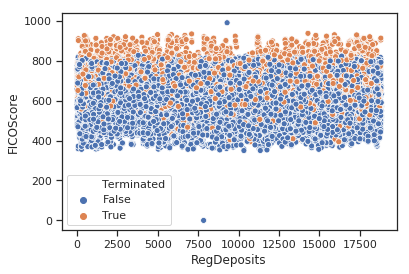

In [76]:
FICO_vs_regdep = churn_df.drop(['Active', 'Balance', 'BankCC', 'PlatStatus', 'Products', 'Sub_id', 'Gen_id', 
'ClientID', 'Firstname', 'Subsidiary', 'Gender', 'Surname', 'Age', 'LifeInsur'], axis=1)
FICO_vs_regdep.head()
FICO_vs_regdep = FICO_vs_regdep.drop(FICO_vs_regdep[FICO_vs_regdep['RegDeposits']  > 20000].index)
sns.scatterplot(x='RegDeposits', y='FICOScore', hue='Terminated', data=FICO_vs_regdep)

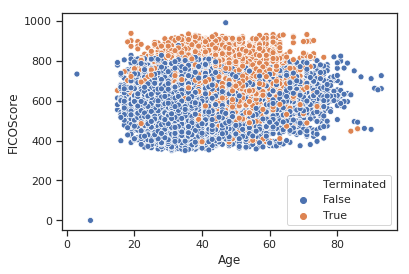

In [77]:
sns.scatterplot(x='Age', y='FICOScore', hue='Terminated', data=churn_df)

# Summary of Recommendations: 
## Based on our analysis, we recommend the following actions:
* Using our random forest model to predict whether a customer will close their account.
* Assign best sales representatives and customer support employees to customers who are about to churn - the largest reason why people leave banks is because of poor customer service. 
* Lowering interest rates on loans for customers with higher FICO credit scores and/or raising interest rates on investments for customers with good FICO credit scores.
* Market life insurance to customers in the age range 40-60.


In [78]:
#---- Fit your favorite model to the Training set 
model = RandomForestRegressor(n_estimators=20, random_state=0)
model.fit(X_train, y_train)

# Save the model to disk; be sure to include this pickle file in the zip file you submit. 
filename = 'S001_TeamGamma_model.sav'
pickle.dump(model, open(filename, 'wb'))